Title: Python Code for Bayesian Filter Models
Date: 2018-08-04
Tags: datascience, bayesian statistics, machine learning
Slug: bayesianfilters
Author: Chris Gagne
Summary: In this post, I share some code that I used to build Bayesian filters.

In this post, I want to share the code that I used to build Bayesian filters. These models are commonly used in robotics (see [Pieter Abbeel's lecture](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa13/slides/bayes-filters.pdf)). However, in neuroscience, we use these models to study how the brain represents different (higher order) levels of uncertainty. The two most relevant neuroscientific papers are [Behrens 2007](http://www.nature.com/neuro/journal/v10/n9/abs/nn1954.html), and [Boorman 2016](http://dx.doi.org/10.1016/j.neuron.2016.02.014). (The authors of these papers kindly shared their matlab code, which I used for my own pythonic implementation).

What are Bayesian filters? Abstractly, filters estimate observed data $x_t$ at a particular time point using observed data up to that time point $ x_0,...,x_{t-1}$. Often, the filters assume the existence of and try to estimate hidden states of the world $z_0, ..., z_{t-1}$ from the observations. The hidden states are usually assumed to be Markovian--the current state only depends on the previous one. 

I'll discuss two alternative models for the hidden state dynamics and step through the code for one of them. First, I'll discuss a model in which the hidden state randomly switches between two values and then I'll discuss a hidden state that drifts as a random walk. 

### The Switching Model

What I'll refer to as the 'switching model' assumes the underlying world consists of two states, randomly alternating between them. Within state 1, outcome A occurs with probability $q$, and outcome B occurs with probability $1-q$. These outcomes are the observed (Bernoulli) variables $x_t \in {0,1}$. Within state 2, the outcome contingencies switch; outcome A occurs with probability $1-q$ and B occurs with probability $q$. 

We'll make the hidden state $z_t \in {0,1}$ whether or not a switch occured.    


The job of the filter model is to first estimate the unknown parameter $q_t$ on each trial

$$ p(q_t | x_0, ..., x_t) $$

and then to predict the next outcome

$$ p(x_t | q_t) $$

How do we do this? The key is to do *recursive estimation*; we start by applying Bayes rule to the first trial and then we use the posterior as the next prior, repeating indefinitely.


Let's import necessary packages. The code can all be found in the [repo](https://github.com/crgagne/crgagne.github.io/content/hierarchical_guassian_filters) for this blog. 

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
%matplotlib inline 
from imp import reload

# import code
import models
reload(models)
from models import * 

# this is for displaying the code from a file
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

def display_code(file,lines):
    file = './'+file
    with open(file) as f:
        code = f.read()
    code = '\n'.join(code.split('\n')[lines[0]:lines[1]])

    formatter = HtmlFormatter()
    return(IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
        formatter.get_style_defs('.highlight'),
        highlight(code, PythonLexer(), formatter))))

#### t=0

Before we have observed anything, we specify a prior for our unknown parameter $p(q_0)$. For this implementation, since we only have 1 hidden parameter $q$, we can construct a uniform prior on possible $q$'s using a grid. (Note: that grid representations of probability densities break down quickly as the dimensionality of the parameter space increases, but we'll be fine for these models). 

In the code printed below, I set up a grid for the prior. Even though our prior is 1-D, I'm making the matrix 3-D so that I don't have to broadcast it later when multiplying by other density functions. (note that the jupyter cell just prints code from 'models.py')

In [68]:
display_code('models.py',[208,210])

Now that we have our prior, we can observe the first observation and calculate our first posterior. We take the observed outcome (either a 1 or 0) and multiply it by each possible value for q (`grid_q`) to created our likelihood grid $p(y_t|q_t)$. 

In [72]:
display_code('models.py',[234,238])

We multiply this likelihood by the prior to get the first posterior.

$$p(q_0|y_0)\propto p(y_0|q_0)p(q_0) $$

In [118]:
display_code('models.py',[248,252])

#### t=1
After the first observation, we also need to consider the probability that $q$ stays the same or switches, which we denote as $p(q_t|q_{t-1})$. Our posterior after two observations is now: 

$$p(q_1|y_0,y_1)\propto p(y_1|q_1)p(q_1|q_0)p(y_0|q_0)p(q_0)$$

We can be simplified by using the posterior from the first (zero'th) observation: 

$$p(q_1|y_0,y_1)\propto p(y_1|q_1)p(q_1|q_0)p(q_0|y_0)$$
 
This multiplication is done in the lines of code below. Note that the `trans_func` refers to  $p(q_t|q_{t-1})$, and that densities are normalized before each multiplication to aid with numerical stability (numbers not getting to small or too big with repeated multiplication). 

In [20]:
display_code('models.py',[246,261])

#### t>1
After the second observation, we repeat for all the observations up to time $t$ using the same procedure. After we are finished, we can get the posterior distribution for $q$ by marginalizing the whole posterior. This is what we'll visualize for the inference.

In [22]:
display_code('models.py',[262,264])

#### Running the code

Let's run the code from from start to finish. I first instantiate a `switch_model` object, then I load in some fake data, and then I run the inference code that we went through above. 

In [150]:
# get example subject 
folder = os.getcwd()
filee = '/example_sub.csv'

# instantiate a model object
switch_model = model_switching(model_name='switching_w_uniform_prior',datafile_name=folder+filee)
switch_model.specify_model_subclass(0)
switch_model.load_data()
switch_model.initialize_parameter_range()
switch_model.initialize_transition()
switch_model.initialize_priors()

# do inference
switch_model.run_inference()

180


After running the code, we can visualize the posterior $p(q_t|y_{0:t})$ for each time point. The color indicates higher probability, the y-axis is the possible value for $q$, the x-axis is time points, the red line is the true probability for $q_t$, which switches every 20 observations and then stays the same after observation #90, and the blue dots are the observations $x_t$.  

We can see that the model is doing a pretty good job at estimating $q_t$, but tends to overshoot the true value (the posterior mean tends to be above or below the red line). We can also see some false alarms after observation #90 when the posterior is higher for $q_t$ around 0.8 even though $q_t$ has not switched. Either way, pretty cool huh!

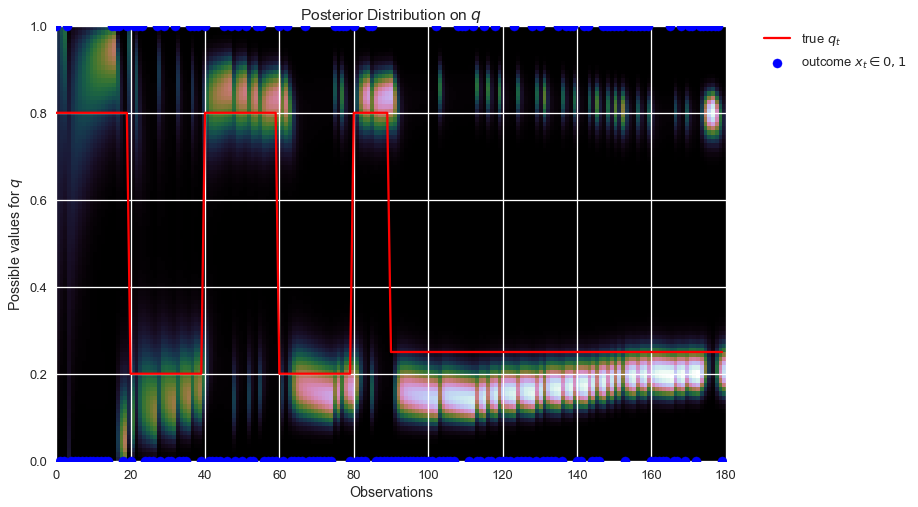

In [144]:
sns.set(rc={'image.cmap': 'cubehelix'})
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(12,8))
ylims = ax.get_ylim()
xlims = [0,180]

# plot outcome and true q
plt.plot(switch_model.data['probabilities'],color='r',label='true $q_t$')
x=switch_model.data['outcome']
plt.scatter(np.arange(len(x)),x,color='b',label='outcome $x_t\in{0,1}$')

# plot posterior
ax.imshow(switch_model.marg_q[:,0:-1],aspect='auto',extent=[xlims[0],xlims[1],ylims[0],ylims[1]],origin='lower')
ax.set_title('Posterior Distribution on $q$')
ax.set_xlabel('Observations')
ax.set_ylabel('Possible values for $q$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Hierarchical Gaussian Model

Instead of assuming that $q$ switches with some fixed probability $p(q_t|q_{t-1})$, we could have assumed that it drifts after each observation by some amount. We'll call the average amount of this drift $v$ for variance, so that now our transition density is $p(q_{t}|q_{t-1},v_{t})$. Furthermore, we could assume that the variance in this drift also changes over time as well $p(v_{t}|v_{t-1},k)$. Then the posterior for $q$ and $v$ on each trial is then given by: 


$$ p(q_{t},v_{t}|y_{1:t-1}) \propto p(y_{t}|q_{t}) \dots $$
$$ \int \int p(q_{t-1}, v_{t-1}, k_{t-1} | y_{1:t-1})p(v_{t}|v_{t-1},k) p(q_{t}|q_{t-1},v_{t}) dv dr $$

See [Behrens 2007](http://www.nature.com/neuro/journal/v10/n9/abs/nn1954.html) for more detail.

I wont go through the code line by line, but it's a very similar implementation to the 'switching model'. We'll just look at the results. 

In [145]:
gaussian_model = model_gaussian_rw(model_name='gaussian_w_uniform_prior',datafile_name=folder+filee)
gaussian_model.specify_model_subclass(0)
gaussian_model.load_data()
gaussian_model.initialize_parameter_range()
gaussian_model.initialize_transition()
gaussian_model.initialize_priors()
gaussian_model.run_inference()
gaussian_model.calc_ev()
gaussian_model.param_temp=10
gaussian_model.calc_prob_choice_softmax()

180


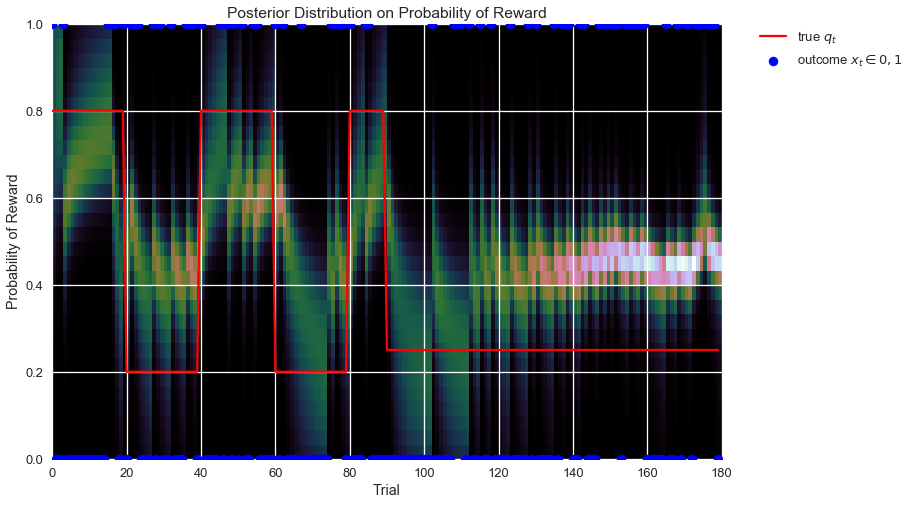

In [147]:
sns.set(rc={'image.cmap': 'cubehelix'})
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(12,8))
ylims = ax.get_ylim()
xlims = [0,180]

# plot outcomes and true q
plt.plot(switch_model.data['probabilities'],color='r',label='true $q_t$')
x=switch_model.data['outcome']
plt.scatter(np.arange(len(x)),x,color='b',label='outcome $x_t\in{0,1}$')

# plot posterior
ax.imshow(gaussian_model.marg_r[:,0:-1],aspect='auto',extent=[xlims[0],xlims[1],ylims[0],ylims[1]],origin='lower')
ax.set_title('Posterior Distribution on Probability of Reward')
ax.set_xlabel('Trial')
ax.set_ylabel('Probability of Reward')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This model has the opposite problem as the 'switching model' in that it tends to underestimate $q$. This is because we are uncertain both about $q_t$ and about how much it is drifting $v_t$. This added uncertainty causes us to estimate that $q_t$ is closer to the center of its range (ie. 0.5).